In [1]:
import ffn 
from empyrical import alpha_beta
#from pypfopt.efficient_frontier import EfficientFrontier
#from pypfopt import risk_models
#from pypfopt import expected_returns
#from pypfopt import discrete_allocation
#from pypfopt import plotting
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np
import pandas as pd

In [2]:
df_INFO   = pd.read_excel('./Trades_Updated_0309.xlsx',sheet_name='INFO')

In [3]:
df_PRICES = pd.read_excel('./Trades_Updated_0309.xlsx',sheet_name='PRICES')
colnames  = df_PRICES.columns.values
colnames[0] = 'Date'
df_PRICES.columns = colnames
df_SIZES  = pd.read_excel('./Trades_Updated_0309.xlsx',sheet_name='SIZE')
colnames  = df_SIZES.columns.values
colnames[0] = 'Date'
df_SIZES.columns = colnames
df_PtB    = pd.read_excel('./Trades_Updated_0309.xlsx',sheet_name='PRICE TO BOOK')
colnames  = df_PtB.columns.values
colnames[0] = 'Date'
df_PtB.columns = colnames

df_PRICES['Date'] = pd.to_datetime(df_PRICES['Date'])
df_SIZES['Date']  = pd.to_datetime(df_SIZES['Date'])
df_PtB['Date']    = pd.to_datetime(df_PtB['Date'])

df_PRICES = df_PRICES.set_index('Date')
df_SIZES = df_SIZES.set_index('Date')
df_PtB = df_PtB.set_index('Date')

In [4]:
# example
df_PRICES.iloc[:3,:6]

,BT.A-GB,CCL-GB,MKS-GB,BARC-GB,ITRK-GB,BRBY-GB
Date,,,,,,
2018-12-31,100.00000,100.000000,100.00000,100.00000,100.000000,100.00000
2019-01-02,100.41382,101.683780,99.94125,99.72475,99.971680,99.04486
2019-01-03,100.11307,98.434883,100.88558,99.10764,95.307976,92.87219


In [5]:
# Step 1: Convert prices into returns
Returns = np.log(df_PRICES / np.roll(df_PRICES.values,1,axis=0))
Returns = Returns.iloc[1:]
Returns.iloc[:3,:6]

,BT.A-GB,CCL-GB,MKS-GB,BARC-GB,ITRK-GB,BRBY-GB
Date,,,,,,
2019-01-02,0.004130,0.016698,-0.000588,-0.002756,-0.000283,-0.009597
2019-01-03,-0.003000,-0.032473,0.009404,-0.006207,-0.047773,-0.064349
2019-01-04,-0.003616,0.028332,0.015439,0.039607,0.054749,0.052771


In [196]:
# Look at two factors: momentum and price to book

# Momentum over last T days...
T = 30
momentum = Returns.iloc[-T:].mean(axis=0)
momentum_deciles, bins = pd.qcut(momentum, q = np.arange(0,1.01,0.2), retbins=True)

In [197]:
bincenters = np.round(((np.roll(bins,-1) + bins)/2)[:-1],4)
momentum_deciles = momentum_deciles.apply(lambda x: np.argmin(np.abs(x.mid - bincenters))+1)

In [198]:
# Book to market
BtM = df_PtB.iloc[-T:].mean(axis=0).apply(lambda x: 1/x)
BtM_deciles, bins = pd.qcut(BtM, q = np.arange(0,1.01,0.2), retbins=True)
bincenters = np.round(((np.roll(bins,-1) + bins)/2)[:-1],4)
BtM_deciles = BtM_deciles.apply(lambda x: np.argmin(np.abs(x.mid - bincenters))+1)
# Sizes
sizes = df_SIZES.iloc[-T:].mean(axis=0)
size_deciles, bins = pd.qcut(sizes, q = np.arange(0,1.01,0.2), retbins=True)
bincenters = np.round(((np.roll(bins,-1) + bins)/2)[:-1],4)
size_deciles = size_deciles.apply(lambda x: np.argmin(np.abs(x.mid - bincenters))+1)

In [199]:
a = pd.DataFrame({'Momentum':momentum_deciles})
b = pd.DataFrame({'BtM':BtM_deciles})
c = pd.DataFrame({'Sizes':size_deciles})
d = pd.merge(a,b, left_index=True, right_index=True)
d = pd.merge(d,c, left_index=True, right_index=True)
d['AvgRet'] = momentum
d.groupby(['BtM','Sizes'])['AvgRet'].mean().unstack()

Sizes,1,2,3,4,5
BtM,,,,,
1,0.000600,0.000769,-0.000845,-0.000119,-0.000257
2,0.000652,0.000959,-0.000048,-0.000614,-0.000803
3,0.000389,-0.000445,0.000141,-0.000004,-0.000218
4,0.000794,0.000563,0.000995,-0.000603,-0.001298
5,-0.000111,-0.000410,0.000067,-0.002574,-0.001163


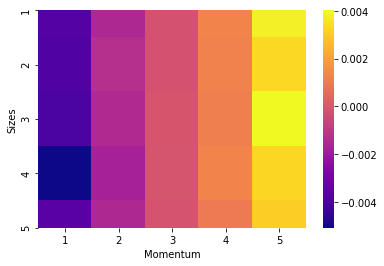

In [200]:
import numpy as np; np.random.seed(0)
import seaborn as sns
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(d.groupby(['Sizes','Momentum'])['AvgRet'].mean().unstack(),cmap='plasma')

In [ ]:
stocks2 = d.reset_index().set_index(['Sizes','Momentum']).loc[1,5]

In [217]:
len(np.intersect1d(stocks2['index'].unique(),stocks1['index'].unique()))

13

In [216]:
len(np.setdiff1d(stocks2['index'].unique(),stocks1['index'].unique()))

19

In [33]:
# Get bad performing industries over last 6 months
# Get timedelta in days
timedelta = np.array([w.days for w in (pd.Timestamp.now() - Returns.index)])
# Extract returns of last 180 days
R = Returns[timedelta<3]
indus = pd.DataFrame(df_INFO.set_index('CODE')['INDUSTRY'])
indus['AvgRet'] = R.mean(axis=0)
# Get mean return by industry
indus = indus.groupby('INDUSTRY').AvgRet.mean().sort_values()
# Select industries with positive mean return
to_keep = indus[indus > 0].index
# Select companies to keep
df_INFO = df_INFO[df_INFO.INDUSTRY.apply(lambda x: x in to_keep)]

In [34]:
Returns = Returns.T.loc[df_INFO.CODE].T

In [35]:
# Define period over which to estimate averages
T_invest = 40 # number of days of the investment horizon
timedelta = np.array([w.days for w in (pd.Timestamp.now() - Returns.index)])
cov_mat = Returns[timedelta<3].cov()
R = Returns[timedelta<3].values

Text(0, 0.5, '$E(r)$')

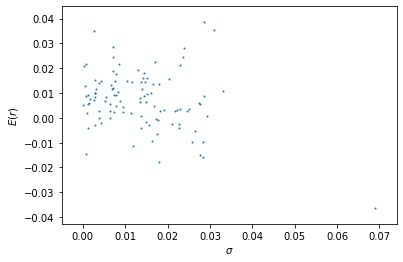

In [36]:
# Get average return over last time
mu = R.mean(axis=0)
# Get variance over last time
std = R.std(axis=0)
plt.scatter(std,mu,s=1)
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$E(r)$')

In [37]:
R.shape

(2, 104)

In [38]:
# Define weights vector. Initialize at 1/600 for all 
omega = pd.DataFrame({'Weight':np.ones(R.shape[1])*(1/R.shape[1])},index=df_INFO.CODE[:R.shape[1]])
omega.head(3)

,Weight
CODE,
BRBY-GB,0.009615
ADS-DE,0.009615
OR-FR,0.009615


In [39]:
# Optimize function under constraints
def sum_eq_1(w):
    # The sum of the weights should be unity
    return np.sum(w)-1

def grade_func(w):
    f = np.dot(w, mu) - 0.25*np.sqrt(np.dot(w.T,np.dot(cov_mat,w)))
    # Return the negative value since we minimize
    return -1*f

# Extract omega start values from pandas df
omega_arr = omega.values.reshape(-1)
# Set bounds for weights to strictly positive
cons = [{'type':'eq', 'fun': sum_eq_1}]
result = minimize(grade_func, omega_arr,bounds=len(omega)*[(0,0.15)],constraints=cons)

In [40]:
df_INFO['OptimalWeight'] = result.x
df_INFO['OptimalWeight'] = df_INFO['OptimalWeight'].round(6)

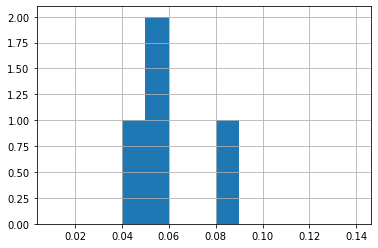

In [41]:
df_INFO['OptimalWeight'].hist(bins=np.arange(0.01,0.15,0.01))

In [42]:
(np.round(result.x,80)>0).sum()

45

In [43]:
df_INFO.sort_values(by='OptimalWeight').tail(20)

,CODE,COMPANY NAME,COUNTRY,INDUSTRY,OptimalWeight
150,EVD-DE,CTS Eventim AG & Co. KGaA,Germany,Movies/Entertainment,0.000000
145,PKN-PL,Polski Koncern Naftowy ORLEN S.A.,Poland,Oil Refining/Marketing,0.000000
160,LISN-CH,Chocoladefabriken Lindt & Spruengli AG,Switzerland,Food: Specialty/Candy,0.000000
138,TEF-ES,Telefonica SA,Spain,Specialty Telecommunications,0.000000
107,BARN-CH,Barry Callebaut AG,Switzerland,Food: Specialty/Candy,0.000000
108,VOW3-DE,Volkswagen AG Pref,Germany,Motor Vehicles,0.000000
141,BMW-DE,Bayerische Motoren Werke AG,Germany,Motor Vehicles,0.000000
111,KER-FR,Kering SA,France,Apparel/Footwear,0.000000
112,DAI-DE,Daimler AG,Germany,Motor Vehicles,0.000000
134,ELISA-FI,Elisa Oyj Class A,Finland,Specialty Telecommunications,0.000000


In [45]:
df_INFO.groupby('INDUSTRY').OptimalWeight.mean()

INDUSTRY
Advertising/Marketing Services        0.050000
Alternative Power Generation          0.000000
Apparel/Footwear                      0.000000
Auto Parts: OEM                       0.050000
Automotive Aftermarket                0.000000
Beverages: Alcoholic                  0.006540
Chemicals: Major Diversified          0.000000
Chemicals: Specialty                  0.015000
Food: Specialty/Candy                 0.000000
Household/Personal Care               0.000000
Marine Shipping                       0.000000
Media Conglomerates                   0.000000
Metal Fabrication                     0.000000
Motor Vehicles                        0.000000
Movies/Entertainment                  0.000000
Oil Refining/Marketing                0.000000
Other Consumer Specialties            0.048019
Personnel Services                    0.000000
Pulp & Paper                          0.006727
Specialty Telecommunications          0.021429
Trucking                              0.000000
Truc

In [62]:
a=df_INFO['COMPANY NAME'].str.contains('Ad')
df_INFO[a]

,CODE,COMPANY NAME,COUNTRY,INDUSTRY
183,ADEN-CH,Adecco Group AG,Switzerland,Personnel Services
440,ADDT.B-SE,Addtech AB Class B,Sweden,Electronic Production Equipment
472,ADM-GB,Admiral Group plc,United Kingdom,Property/Casualty Insurance
587,ADYEN-NL,Adyen NV,Netherlands,Packaged Software
594,ADE-NO,Adevinta ASA,Norway,Advertising/Marketing Services
